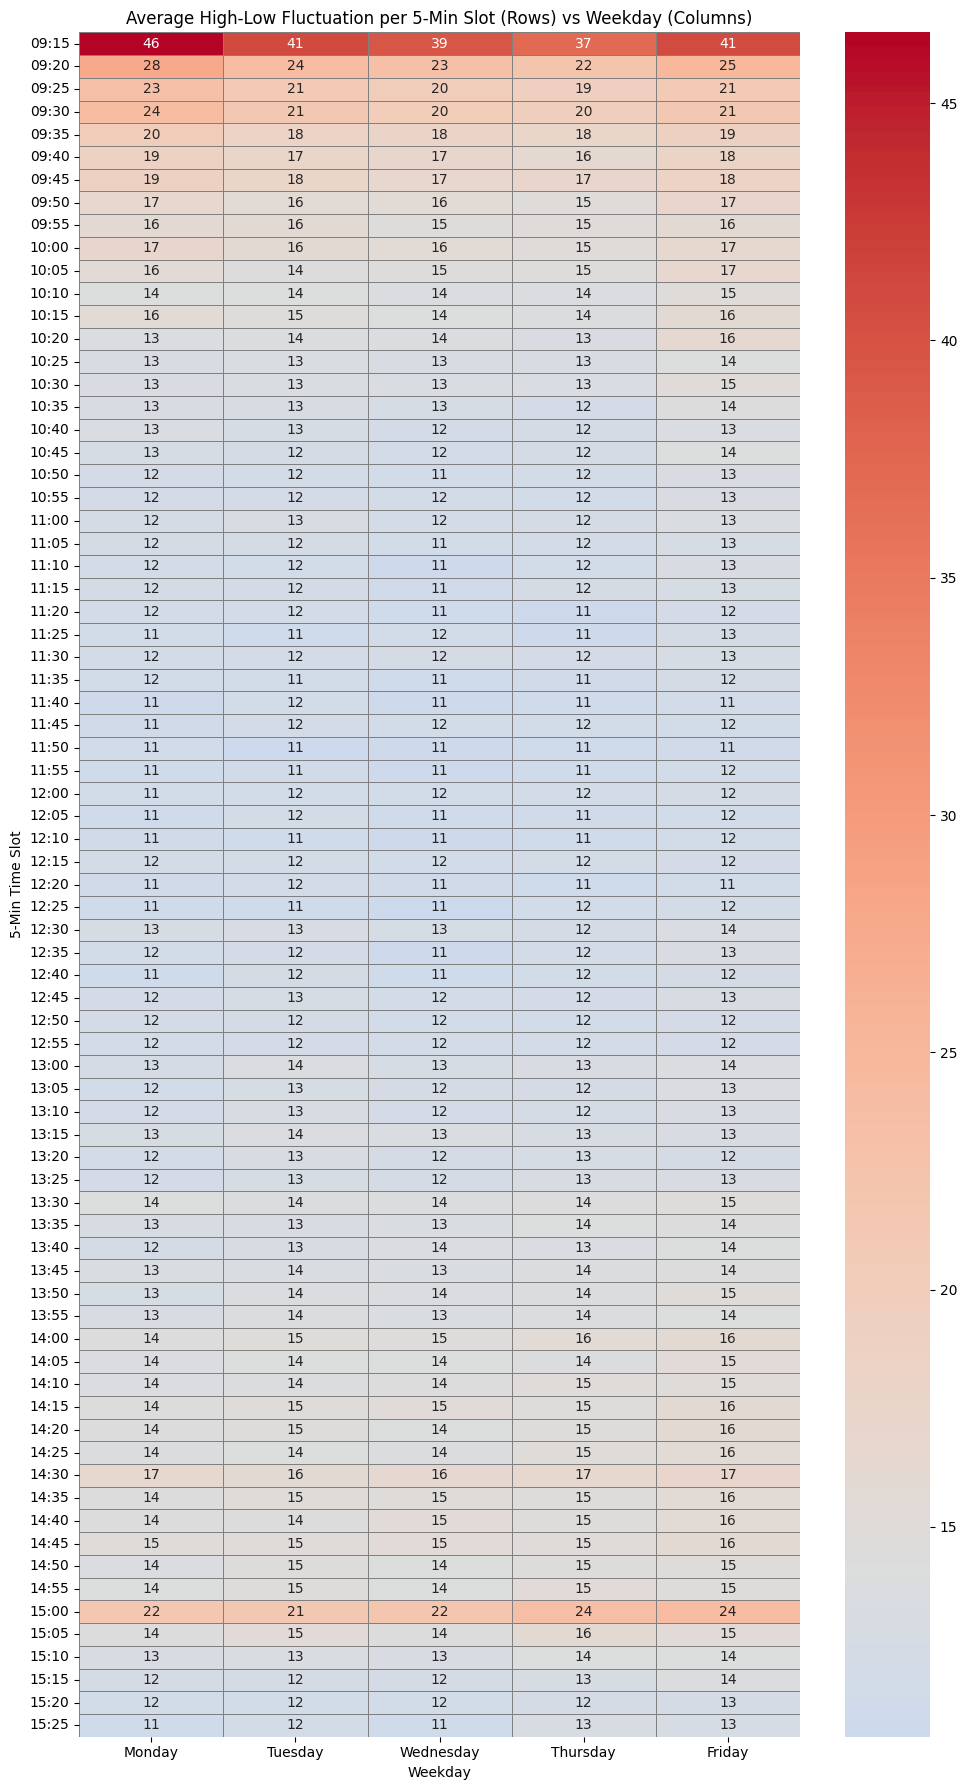

In [1]:
# average difference 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and parse data
df = pd.read_csv(r"C:\project stt\nifty50_5min.csv")
df['date'] = pd.to_datetime(df['date'])

# Step 2: Compute fluctuation
df['fluctuation'] = df['high'] - df['low']

# Step 3: Extract required time features
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['weekday'] = df['date'].dt.weekday      # 0 = Monday
df['time_slot'] = df['date'].dt.strftime('%H:%M')  # For row labels in heatmap

# Step 4: Filter market time window (09:30 to 15:25)
df = df[
    ((df['hour'] == 9) & (df['minute'] >= 15)) |
    ((df['hour'] > 9) & (df['hour'] < 15)) |
    ((df['hour'] == 15) & (df['minute'] <= 25))
]

# Step 5: Remove weekends (Saturday = 5, Sunday = 6)
df = df[df['weekday'] <= 4]

# Step 6: Group by time slot and weekday, calculate average fluctuation
grouped = df.groupby(['time_slot', 'weekday'])['fluctuation'].mean().reset_index()

# Step 7: Pivot table: rows = time_slot, columns = weekday
heatmap_df = grouped.pivot(index='time_slot', columns='weekday', values='fluctuation')

# Step 8: Rename columns to weekday names
heatmap_df.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Step 9: Sort time slots in order
heatmap_df = heatmap_df.sort_index()


# Step 10: Plot heatmap
plt.figure(figsize=(10, 18))
# sns.heatmap(heatmap_df, annot=True, cmap='YlOrRd', linewidths=0.5, linecolor='gray')
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap='coolwarm',  # diverging color map
    linewidths=0.5,
    linecolor='gray',
    center=heatmap_df.stack().mean()  # center the colormap around average
)

plt.title('Average High-Low Fluctuation per 5-Min Slot (Rows) vs Weekday (Columns)')
plt.xlabel('Weekday')
plt.ylabel('5-Min Time Slot')
plt.tight_layout()
plt.show()


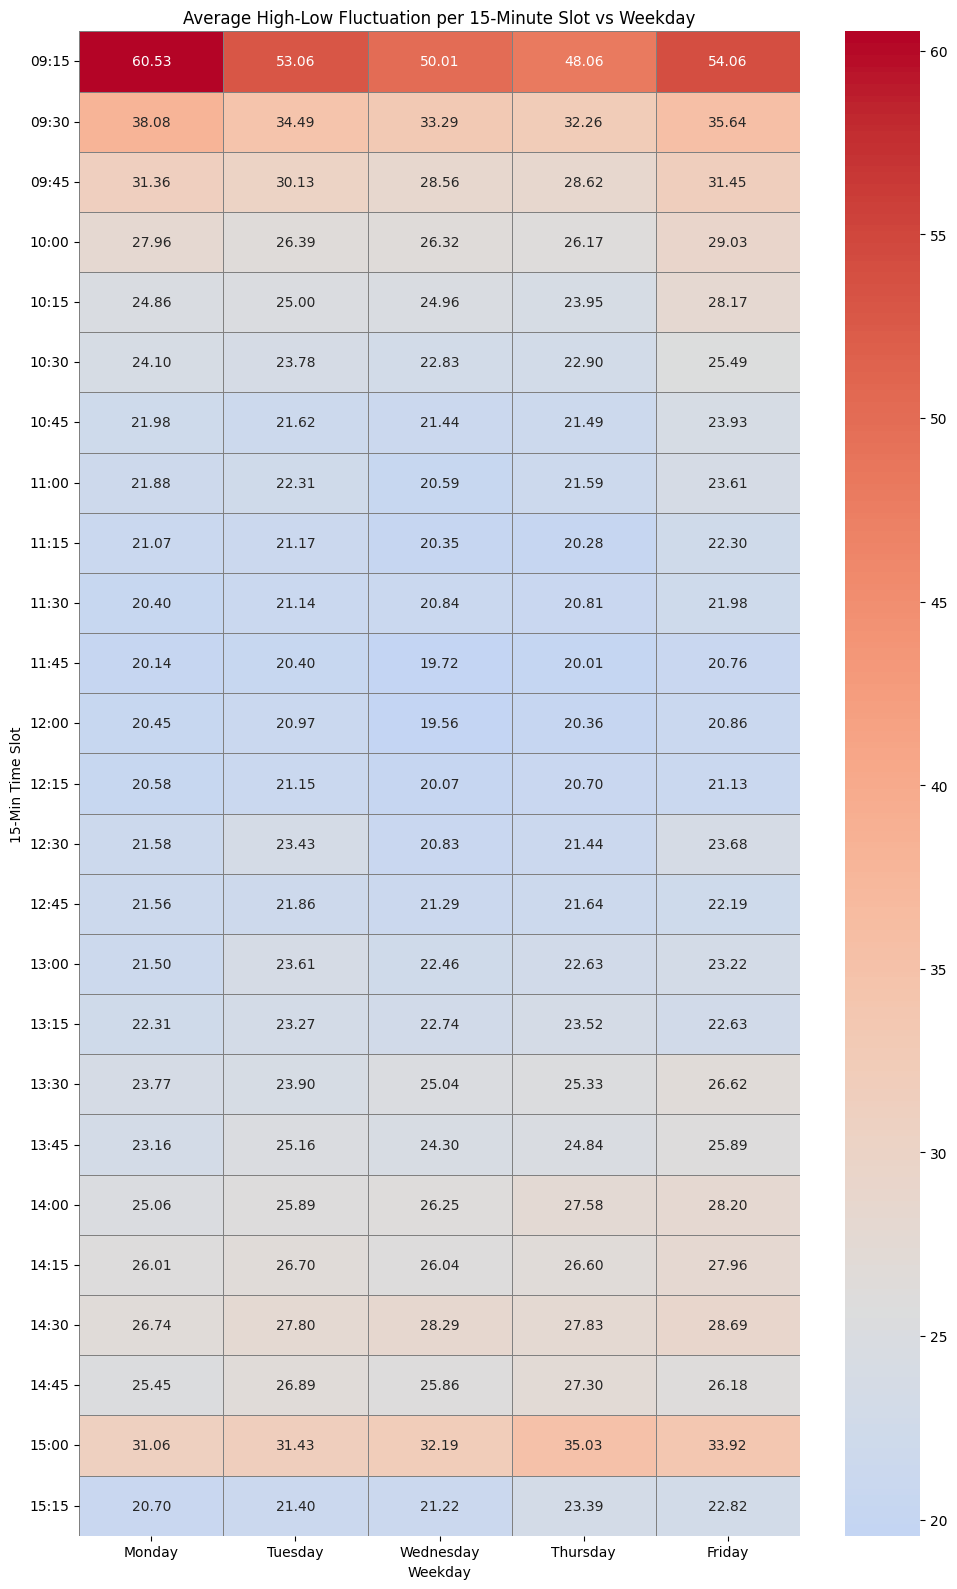

In [2]:
# average difference for 15 min


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and parse data
df = pd.read_csv(r"C:\project stt\resampled_15min_data.csv")
df['date'] = pd.to_datetime(df['date'])

# Step 2: Compute fluctuation
df['fluctuation'] = df['high'] - df['low']

# Step 3: Extract time and weekday
df['time_slot'] = df['date'].dt.strftime('%H:%M')
df['weekday'] = df['date'].dt.weekday  # 0 = Monday, 4 = Friday

# Step 4: Filter only trading time (09:15 to 15:30) and weekdays
df = df[
    ((df['date'].dt.hour == 9) & (df['date'].dt.minute >= 15)) |
    ((df['date'].dt.hour > 9) & (df['date'].dt.hour < 15)) |
    ((df['date'].dt.hour == 15) & (df['date'].dt.minute <= 30))
]
df = df[df['weekday'] <= 4]  # Remove weekends

# Step 5: Group by time slot and weekday
grouped = df.groupby(['time_slot', 'weekday'])['fluctuation'].mean().reset_index()

# Step 6: Pivot for heatmap
heatmap_df = grouped.pivot(index='time_slot', columns='weekday', values='fluctuation')

# Step 7: Rename columns
heatmap_df.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Step 8: Sort time slots
heatmap_df = heatmap_df.sort_index()

# Step 9: Plot heatmap
plt.figure(figsize=(10, 16))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    center=heatmap_df.stack().mean()
)

plt.title('Average High-Low Fluctuation per 15-Minute Slot vs Weekday')
plt.xlabel('Weekday')
plt.ylabel('15-Min Time Slot')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\saiga\AppData\Local\Temp\ipykernel_20012\3179705884.py:96: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saiga\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


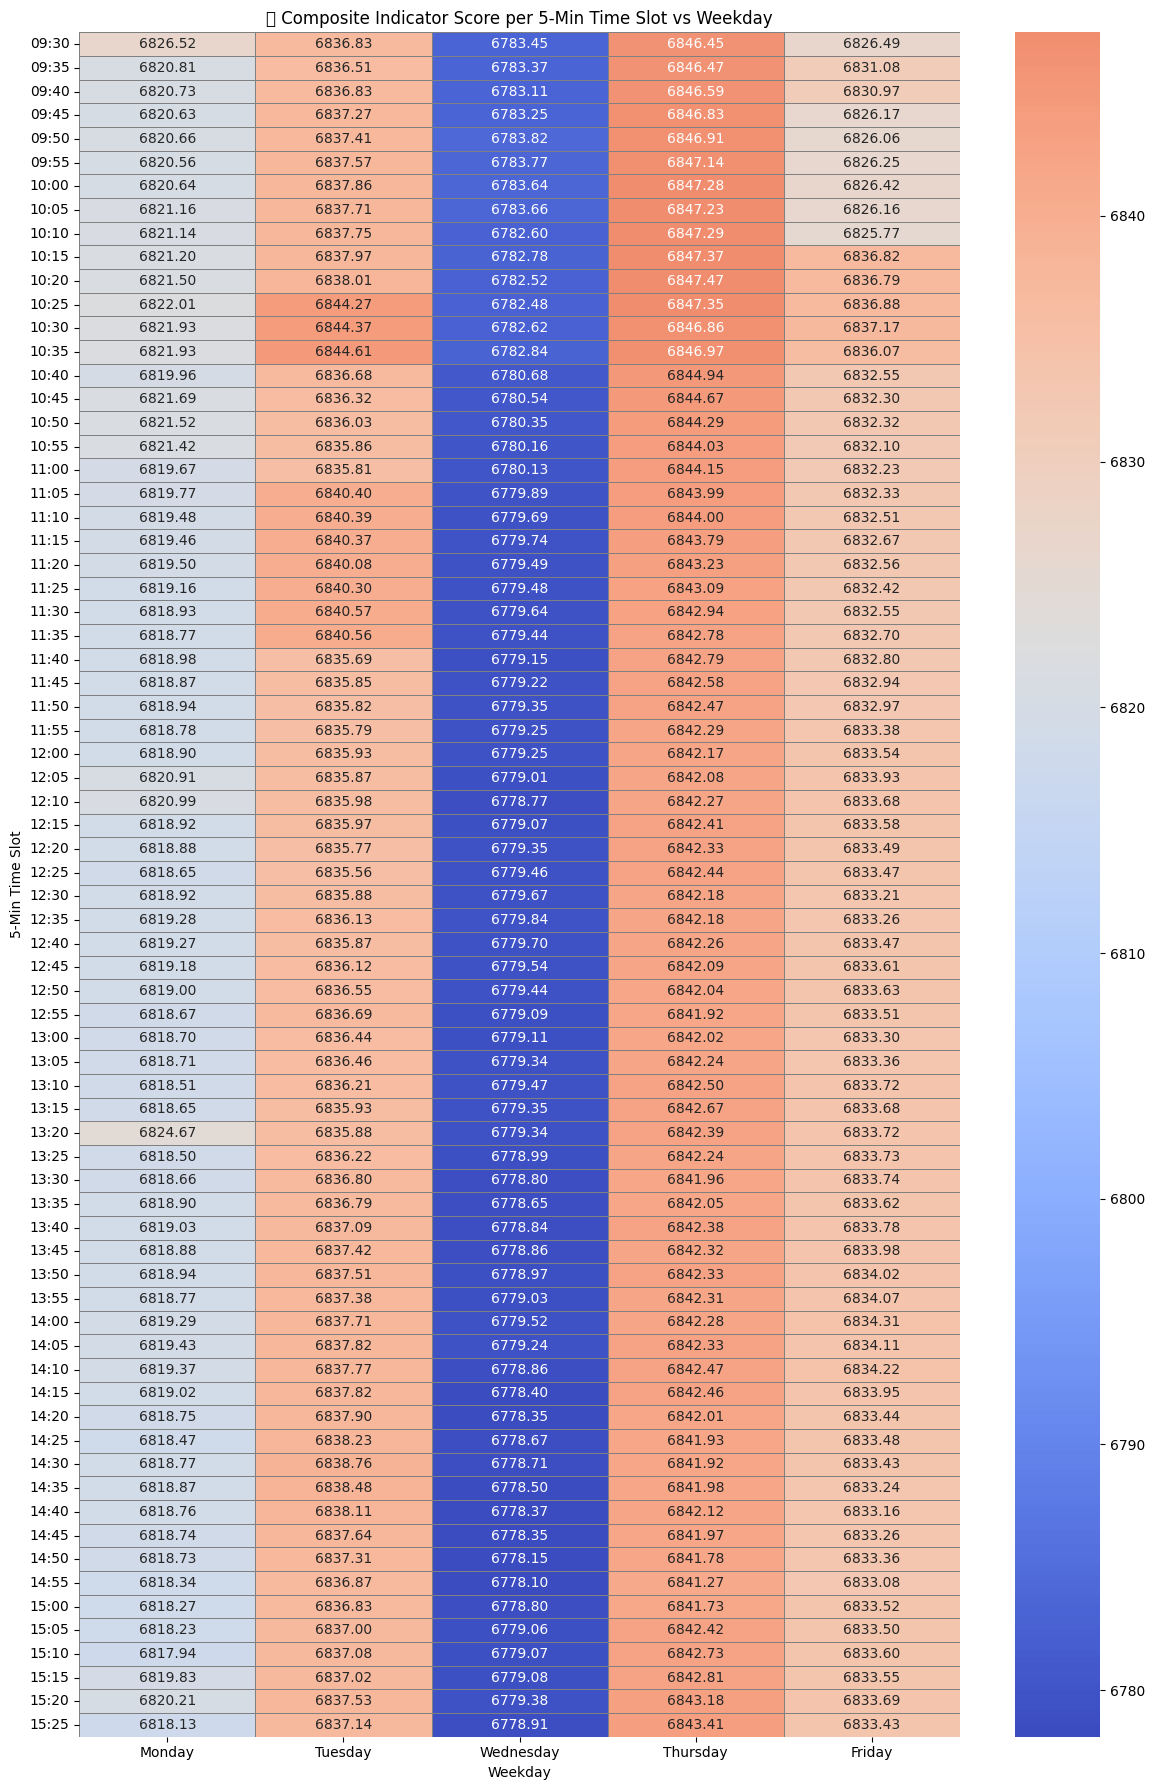

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Load and parse data
df = pd.read_csv(r"C:\project stt\nifty50_5min.csv")
df['date'] = pd.to_datetime(df['date'])

# Step 2: Compute fluctuation
df['fluctuation'] = df['high'] - df['low']

# Step 3: Extract time features
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['weekday'] = df['date'].dt.weekday  # Monday=0, Sunday=6
df['time_slot'] = df['date'].dt.strftime('%H:%M')

# Step 4: Filter trading hours (09:30 to 15:25)
df = df[
    ((df['hour'] == 9) & (df['minute'] >= 30)) |
    ((df['hour'] > 9) & (df['hour'] < 15)) |
    ((df['hour'] == 15) & (df['minute'] <= 25))
]

# Step 5: Remove weekends
df = df[df['weekday'] <= 4]

# Step 6: Technical Indicators

# ➤ RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = compute_rsi(df['close'])

# ➤ MACD
exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp1 - exp2
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# ➤ VWAP (approximation using average price)
df['vwap'] = ((df['high'] + df['low'] + df['close']) / 3).rolling(window=14).mean()

# ➤ SuperTrend components
df['hl'] = df['high'] - df['low']
df['hc'] = abs(df['high'] - df['close'].shift(1))
df['lc'] = abs(df['low'] - df['close'].shift(1))
df['tr'] = df[['hl', 'hc', 'lc']].max(axis=1)
df['atr'] = df['tr'].rolling(window=10).mean()
df['supertrend_upper'] = ((df['high'] + df['low']) / 2) + (2 * df['atr'])
df['supertrend_lower'] = ((df['high'] + df['low']) / 2) - (2 * df['atr'])

# ➤ ADX
df['up_move'] = df['high'] - df['high'].shift(1)
df['down_move'] = df['low'].shift(1) - df['low']
df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
df['plus_di'] = 100 * (df['plus_dm'].rolling(window=14).mean() / df['atr'])
df['minus_di'] = 100 * (df['minus_dm'].rolling(window=14).mean() / df['atr'])
df['adx'] = 100 * abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di'])

# ➤ Composite Score
df['indicator_score'] = df[['rsi', 'macd', 'vwap', 'supertrend_upper', 'supertrend_lower', 'adx']].mean(axis=1)

# Step 7: Group by time slot and weekday
grouped = df.groupby(['time_slot', 'weekday'])['indicator_score'].mean().reset_index()

# Step 8: Pivot for heatmap
heatmap_df = grouped.pivot(index='time_slot', columns='weekday', values='indicator_score')
heatmap_df.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
heatmap_df = heatmap_df.sort_index()

# Step 9: Plot heatmap
plt.figure(figsize=(12, 18))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    center=heatmap_df.stack().mean()
)
plt.title('📊 Composite Indicator Score per 5-Min Time Slot vs Weekday')
plt.xlabel('Weekday')
plt.ylabel('5-Min Time Slot')
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1️⃣ Drop rows with NaNs (from rolling calculations)
df.dropna(inplace=True)

# 2️⃣ Define features and target
features = ['rsi', 'macd', 'vwap', 'supertrend_upper', 'supertrend_lower', 'adx']
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)  # 1 if next close is higher

# Drop last row with NaN target
df.dropna(inplace=True)

X = df[features]
y = df['target']

# 3️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4️⃣ Train ML model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 5️⃣ Evaluate
y_pred = clf.predict(X_test)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📝 Classification Report:\n", classification_report(y_test, y_pred))


KeyboardInterrupt: 

C:\Users\saiga\AppData\Local\Temp\ipykernel_20012\3734198245.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\saiga\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


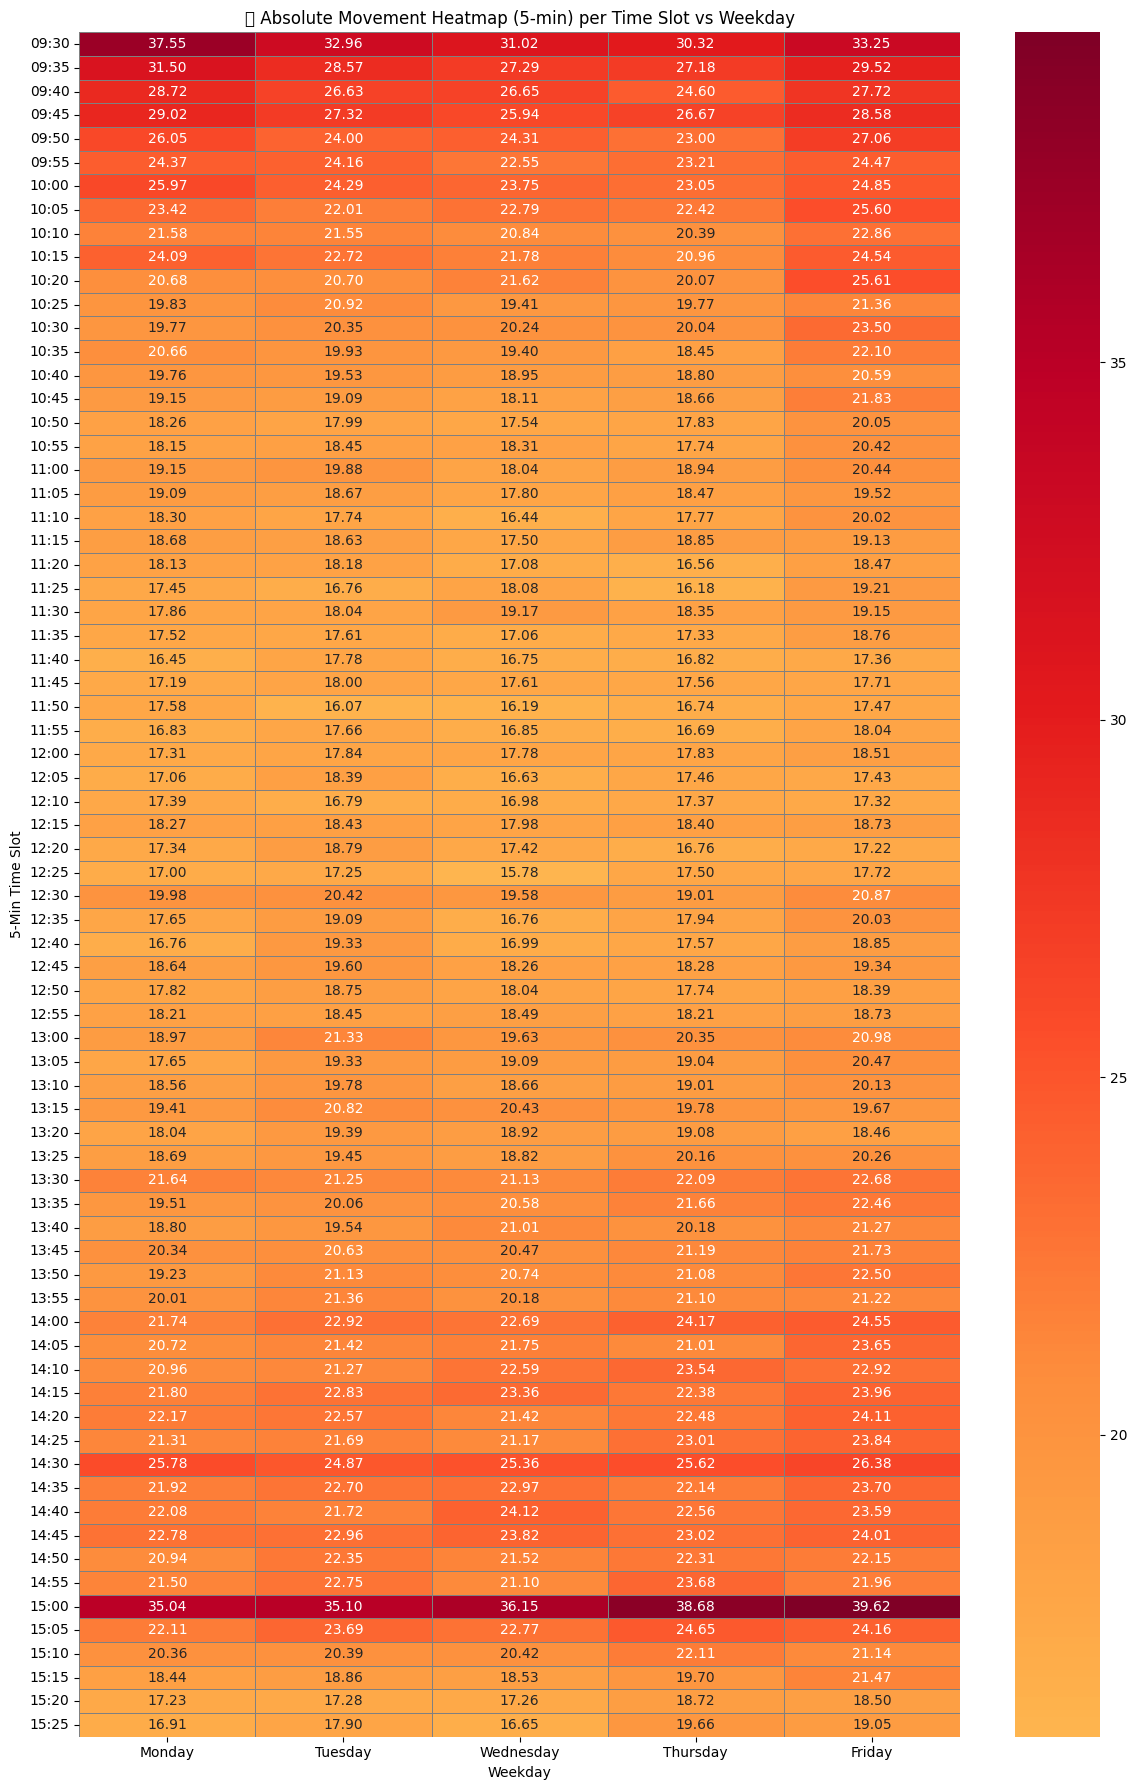

In [9]:
#absolute 5min

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Load your 5-min data
df = pd.read_csv(r"C:\project stt\nifty50_5min.csv")
df['date'] = pd.to_datetime(df['date'])

# 2️⃣ Extract time slots and weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['weekday'] = df['date'].dt.weekday  # Monday=0
df['time_slot'] = df['date'].dt.strftime('%H:%M')

# 3️⃣ Filter for market hours (09:30 to 15:25)
df = df[
    ((df['hour'] == 9) & (df['minute'] >= 30)) |
    ((df['hour'] > 9) & (df['hour'] < 15)) |
    ((df['hour'] == 15) & (df['minute'] <= 25))
]

# 4️⃣ Remove weekends
df = df[df['weekday'] <= 4]

# 5️⃣ Calculate absolute movement
df['abs_movement'] = (
    abs(df['close'] - df['open']) +
    abs(df['high'] - df['close']) +
    abs(df['close'] - df['low'])
)

# Alternative: some use |High - Low| + |Close - Open|
# df['abs_movement'] = abs(df['high'] - df['low']) + abs(df['close'] - df['open'])

# 6️⃣ Group by time slot & weekday, take mean
grouped = df.groupby(['time_slot', 'weekday'])['abs_movement'].mean().reset_index()

# 7️⃣ Pivot for heatmap
heatmap_df = grouped.pivot(index='time_slot', columns='weekday', values='abs_movement')
heatmap_df.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
heatmap_df = heatmap_df.sort_index()

# 8️⃣ Plot heatmap
plt.figure(figsize=(12, 18))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2f",
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    center=heatmap_df.stack().mean()
)
plt.title('📊 Absolute Movement Heatmap (5-min) per Time Slot vs Weekday')
plt.xlabel('Weekday')
plt.ylabel('5-Min Time Slot')
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd

# Load your 5-min data
df = pd.read_csv(r"C:\project stt\nifty50_5min.csv")
df['date'] = pd.to_datetime(df['date'])

# Extract time slots & weekday
df['weekday'] = df['date'].dt.weekday  # 0=Monday
df['time_slot'] = df['date'].dt.strftime('%H:%M')

# Market hours filter
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df = df[
    ((df['hour'] == 9) & (df['minute'] >= 30)) |
    ((df['hour'] > 9) & (df['hour'] < 15)) |
    ((df['hour'] == 15) & (df['minute'] <= 25))
]
df = df[df['weekday'] <= 4]

# Calculate High-Low difference
df['fluctuation'] = df['high'] - df['low']

# Group and pivot
grouped_avg = df.groupby(['time_slot', 'weekday'])['fluctuation'].mean().reset_index()
heatmap_avg_diff = grouped_avg.pivot(index='time_slot', columns='weekday', values='fluctuation')
heatmap_avg_diff.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
heatmap_avg_diff = heatmap_avg_diff.sort_index()

# Optional: Save
heatmap_avg_diff.to_csv('heatmap_avg_diff.csv')


In [12]:
# Calculate Absolute Movement
df['abs_movement'] = (
    abs(df['close'] - df['open']) +
    abs(df['high'] - df['close']) +
    abs(df['close'] - df['low'])
)

# Group and pivot
grouped_abs = df.groupby(['time_slot', 'weekday'])['abs_movement'].mean().reset_index()
heatmap_abs_move = grouped_abs.pivot(index='time_slot', columns='weekday', values='abs_movement')
heatmap_abs_move.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
heatmap_abs_move = heatmap_abs_move.sort_index()

# Optional: Save
heatmap_abs_move.to_csv('heatmap_abs_move.csv')


In [13]:
#identify the most volatile time slots to trade in. Pick the top 20–30% slots and save them as your ‘High Volatility Windows’


import pandas as pd

# 1️⃣ Combine both heatmaps by averaging
combined_heatmap = (heatmap_avg_diff + heatmap_abs_move) / 2

# 2️⃣ Flatten to long format
flattened = combined_heatmap.stack().reset_index()
flattened.columns = ['TimeSlot', 'DayOfWeek', 'CombinedScore']

# 3️⃣ Sort by Combined Score descending
flattened = flattened.sort_values(by='CombinedScore', ascending=False).reset_index(drop=True)

# 4️⃣ Pick top X% slots (e.g., 20%)
top_percent = 0.2   # Adjust: 0.2 for 20%, 0.3 for 30%
top_count = int(len(flattened) * top_percent)
top_slots = flattened.head(top_count)

# 5️⃣ Show threshold value for reference
threshold_value = top_slots['CombinedScore'].iloc[-1]
print(f"✅ Top {top_percent*100:.0f}% most volatile slots (Combined Score ≥ {threshold_value:.2f}):\n")
print(top_slots)

# 6️⃣ Save to CSV
top_slots.to_csv('high_volatility_slots.csv', index=False)
print("\n📁 Saved to 'high_volatility_slots.csv' for later filtering!")


✅ Top 20% most volatile slots (Combined Score ≥ 18.91):

   TimeSlot  DayOfWeek  CombinedScore
0     15:00     Friday      31.914745
1     15:00   Thursday      31.105500
2     09:30     Monday      30.744067
3     15:00  Wednesday      28.982450
4     15:00     Monday      28.313411
..      ...        ...            ...
67    14:45    Tuesday      19.021586
68    09:50   Thursday      19.013100
69    14:25   Thursday      18.961300
70    14:00    Tuesday      18.918524
71    14:35  Wednesday      18.913050

[72 rows x 3 columns]

📁 Saved to 'high_volatility_slots.csv' for later filtering!


In [14]:
#Combines your two heatmaps
# Standardizes TimeSlot to 'HH:MM' with leading zeros
# Ensures DayOfWeek is numeric 0–4
# Picks top 30% slots
# Saves high_volatility_slots.csv
# Loads your OHLCV, re-checks the format
# Applies the slots filter correctly
# Generates signals
# Runs your simple backtest
# Prints your trades with real signals














import pandas as pd
import numpy as np

# -------------------------------------------
# ✅ 1) Combine both heatmaps & fix format
# -------------------------------------------
heatmap_avg_diff = pd.read_csv('heatmap_avg_diff.csv', index_col=0)
heatmap_abs_move = pd.read_csv('heatmap_abs_move.csv', index_col=0)

# Combine
combined_heatmap = (heatmap_avg_diff + heatmap_abs_move) / 2

# Flatten
flattened = combined_heatmap.stack().reset_index()
flattened.columns = ['TimeSlot', 'DayOfWeek', 'CombinedScore']

# 🗝️ Ensure TimeSlot format is always HH:MM with leading zeros
flattened['TimeSlot'] = flattened['TimeSlot'].apply(
    lambda x: f"{int(x.split(':')[0]):02d}:{int(x.split(':')[1]):02d}"
)

# 🗝️ Ensure DayOfWeek is numeric
flattened['DayOfWeek'] = flattened['DayOfWeek'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4
}) if flattened['DayOfWeek'].dtype == 'object' else flattened['DayOfWeek']

# Sort & pick top 30%
flattened = flattened.sort_values(by='CombinedScore', ascending=False).reset_index(drop=True)
top_percent = 0.3
top_count = int(len(flattened) * top_percent)
top_slots = flattened.head(top_count)

# Save slots
top_slots.to_csv('high_volatility_slots.csv', index=False)
print(f"✅ Saved {len(top_slots)} slots to high_volatility_slots.csv")
print(top_slots.head())

# -------------------------------------------
# ✅ 2) Load OHLCV data & fix TimeSlot format
# -------------------------------------------
df = pd.read_csv('nifty50_5min.csv')
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['weekday'] = df['date'].dt.weekday
df['time_slot'] = df['date'].dt.strftime('%H:%M')

# Filter trading hours & weekdays
df = df[
    ((df['hour'] == 9) & (df['minute'] >= 30)) |
    ((df['hour'] > 9) & (df['hour'] < 15)) |
    ((df['hour'] == 15) & (df['minute'] <= 25))
]
df = df[df['weekday'] <= 4]

# -------------------------------------------
# ✅ 3) Indicators
# -------------------------------------------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = compute_rsi(df['close'])

exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp1 - exp2
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

df['sma_20'] = df['close'].rolling(window=20).mean()
df['bb_upper'] = df['sma_20'] + 2 * df['close'].rolling(window=20).std()
df['bb_lower'] = df['sma_20'] - 2 * df['close'].rolling(window=20).std()

# -------------------------------------------
# ✅ 4) Apply slots filter with fixed format
# -------------------------------------------
allowed_slots = set(zip(top_slots['TimeSlot'], top_slots['DayOfWeek']))
df['allowed_slot'] = df.apply(lambda row: (row['time_slot'], row['weekday']) in allowed_slots, axis=1)

print("\nAllowed Slot Counts:")
print(df['allowed_slot'].value_counts())

# -------------------------------------------
# ✅ 5) Generate signals
# -------------------------------------------
df['macd_cross'] = df['macd'] - df['macd_signal']
df['macd_cross_prev'] = df['macd_cross'].shift(1)

conditions_buy = (
    (df['macd_cross'] > 0) &
    (df['macd_cross_prev'] <= 0) &
    (df['rsi'] < 70) &
    (df['allowed_slot'])
)

conditions_sell = (
    (df['macd_cross'] < 0) &
    (df['macd_cross_prev'] >= 0) &
    (df['rsi'] > 30) &
    (df['allowed_slot'])
)

df['signal'] = 0
df.loc[conditions_buy, 'signal'] = 1
df.loc[conditions_sell, 'signal'] = -1

# -------------------------------------------
# ✅ 6) Backtest
# -------------------------------------------
df['next_close'] = df['close'].shift(-1)
df['pnl'] = np.where(
    df['signal'] == 1, df['next_close'] - df['close'],
    np.where(df['signal'] == -1, df['close'] - df['next_close'], 0)
)

trades = df[df['signal'] != 0].copy()
trades['cum_pnl'] = trades['pnl'].cumsum()

print("\n✅ Trades:")
print(trades[['date', 'signal', 'close', 'next_close', 'pnl', 'cum_pnl']].head(10))

print("\n📈 Total Trades:", len(trades))
print("📊 Total PnL:", trades['pnl'].sum())
print("📈 Average PnL per Trade:", trades['pnl'].mean())
print("✅ Win Rate:", (trades['pnl'] > 0).mean())

trades.to_csv('final_adjusted_trades.csv', index=False)
print("\n✅ Final trades saved to final_adjusted_trades.csv")


✅ Saved 108 slots to high_volatility_slots.csv
  TimeSlot  DayOfWeek  CombinedScore
0    15:00          4      31.914745
1    15:00          3      31.105500
2    09:30          0      30.744067
3    15:00          2      28.982450
4    15:00          0      28.313411

Allowed Slot Counts:
allowed_slot
False    125143
True      53553
Name: count, dtype: int64

✅ Trades:
                   date  signal    close  next_close    pnl  cum_pnl
60  2015-01-09 14:15:00       1  8242.10     8236.75  -5.35    -5.35
80  2015-01-12 09:40:00      -1  8271.10     8270.50   0.60    -4.75
83  2015-01-12 09:55:00       1  8285.90     8281.50  -4.40    -9.15
85  2015-01-12 10:05:00      -1  8274.05     8284.10 -10.05   -19.20
294 2015-01-14 15:00:00       1  8279.80     8271.60  -8.20   -27.40
370 2015-01-15 15:05:00      -1  8502.35     8510.75  -8.40   -35.80
377 2015-01-19 09:35:00       1  8549.90     8553.95   4.05   -31.75
436 2015-01-19 14:30:00      -1  8556.95     8554.05   2.90   -28.85
451 20

In [15]:

#1. Uses .iloc[] properly — so you’ll never get that KeyError again
#2. Adds realistic TP/SL forward loop with position handling
#3. Standardized with comments so you can tweak it anytime
#4. Saves your trade log to CSV for your next steps



import pandas as pd
import numpy as np

# -------------------------------------------
# ✅ 1) Load final high-volatility slots
# -------------------------------------------
slots_df = pd.read_csv('high_volatility_slots.csv')
allowed_slots = set(zip(slots_df['TimeSlot'], slots_df['DayOfWeek']))

# -------------------------------------------
# ✅ 2) Load main OHLCV
# -------------------------------------------
df = pd.read_csv('nifty50_5min.csv')
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['weekday'] = df['date'].dt.weekday
df['time_slot'] = df['date'].dt.strftime('%H:%M')

# Filter trading time & weekdays
df = df[
    ((df['hour'] == 9) & (df['minute'] >= 30)) |
    ((df['hour'] > 9) & (df['hour'] < 15)) |
    ((df['hour'] == 15) & (df['minute'] <= 25))
]
df = df[df['weekday'] <= 4]

# Reset index so .iloc[] works safely
df = df.reset_index(drop=True)

# -------------------------------------------
# ✅ 3) Indicators
# -------------------------------------------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = compute_rsi(df['close'])

exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp1 - exp2
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

df['macd_cross'] = df['macd'] - df['macd_signal']
df['macd_cross_prev'] = df['macd_cross'].shift(1)

# Allowed slots filter
df['allowed_slot'] = df.apply(lambda row: (row['time_slot'], row['weekday']) in allowed_slots, axis=1)

# -------------------------------------------
# ✅ 4) Generate signals
# -------------------------------------------
df['signal'] = 0
df.loc[
    (df['macd_cross'] > 0) & (df['macd_cross_prev'] <= 0) &
    (df['rsi'] < 70) & df['allowed_slot'],
    'signal'
] = 1

df.loc[
    (df['macd_cross'] < 0) & (df['macd_cross_prev'] >= 0) &
    (df['rsi'] > 30) & df['allowed_slot'],
    'signal'
] = -1

# -------------------------------------------
# ✅ 5) Backtest with TP/SL using .iloc[] safely
# -------------------------------------------
TP_pct = 0.001  # 0.1% target profit
SL_pct = 0.001  # 0.1% stop loss

trades = []

for idx, row in df.iterrows():
    if row['signal'] != 0:
        entry_price = row['close']
        direction = row['signal']
        stop_loss = entry_price * (1 - SL_pct) if direction == 1 else entry_price * (1 + SL_pct)
        take_profit = entry_price * (1 + TP_pct) if direction == 1 else entry_price * (1 - TP_pct)
        entry_time = row['date']

        exit_price = None
        exit_reason = None

        for fwd_idx in range(idx + 1, len(df)):
            fwd_price = df.iloc[fwd_idx]['close']
            fwd_time = df.iloc[fwd_idx]['date']

            if direction == 1:
                if fwd_price <= stop_loss:
                    exit_price = fwd_price
                    exit_reason = 'SL'
                    break
                elif fwd_price >= take_profit:
                    exit_price = fwd_price
                    exit_reason = 'TP'
                    break
            else:
                if fwd_price >= stop_loss:
                    exit_price = fwd_price
                    exit_reason = 'SL'
                    break
                elif fwd_price <= take_profit:
                    exit_price = fwd_price
                    exit_reason = 'TP'
                    break

        if exit_price is None:
            # TP/SL never hit: exit at last price
            exit_price = fwd_price
            fwd_time = df.iloc[fwd_idx]['date']
            exit_reason = 'NoTP/SL'

        pnl = (exit_price - entry_price) if direction == 1 else (entry_price - exit_price)
        trades.append({
            'EntryTime': entry_time,
            'Direction': direction,
            'EntryPrice': entry_price,
            'ExitTime': fwd_time,
            'ExitPrice': exit_price,
            'PnL': pnl,
            'Reason': exit_reason
        })

# -------------------------------------------
# ✅ 6) Save & review
# -------------------------------------------
trades_df = pd.DataFrame(trades)
trades_df['CumPnL'] = trades_df['PnL'].cumsum()

print("\n✅ Example trades:")
print(trades_df.head(10))

print("\n✅ Total Trades:", len(trades_df))
print("📈 Total PnL:", trades_df['PnL'].sum())
print("📊 Average PnL per Trade:", trades_df['PnL'].mean())
print("✅ Win Rate:", (trades_df['PnL'] > 0).mean())

trades_df.to_csv('phase3_trades_with_tp_sl.csv', index=False)
print("\n📁 Trades saved to 'phase3_trades_with_tp_sl.csv'")



✅ Example trades:
            EntryTime  Direction  EntryPrice            ExitTime  ExitPrice  \
0 2015-01-09 14:15:00          1     8242.10 2015-01-09 14:35:00    8252.55   
1 2015-01-12 09:40:00         -1     8271.10 2015-01-12 09:55:00    8285.90   
2 2015-01-12 09:55:00          1     8285.90 2015-01-12 10:05:00    8274.05   
3 2015-01-12 10:05:00         -1     8274.05 2015-01-12 10:10:00    8284.10   
4 2015-01-14 15:00:00          1     8279.80 2015-01-15 09:30:00    8430.10   
5 2015-01-15 15:05:00         -1     8502.35 2015-01-15 15:20:00    8463.55   
6 2015-01-19 09:35:00          1     8549.90 2015-01-19 10:00:00    8558.80   
7 2015-01-19 14:30:00         -1     8556.95 2015-01-19 15:15:00    8547.70   
8 2015-01-20 09:30:00          1     8589.00 2015-01-20 10:10:00    8598.30   
9 2015-01-21 14:45:00          1     8731.20 2015-01-22 09:30:00    8744.45   

      PnL Reason  CumPnL  
0   10.45     TP   10.45  
1  -14.80     SL   -4.35  
2  -11.85     SL  -16.20  
3  

In [16]:
#trailing stops


import pandas as pd
import numpy as np

# -------------------------------------------
# ✅ 1) Load your high-volatility slots
# -------------------------------------------
slots_df = pd.read_csv('high_volatility_slots.csv')
allowed_slots = set(zip(slots_df['TimeSlot'], slots_df['DayOfWeek']))

# -------------------------------------------
# ✅ 2) Load your OHLCV data
# -------------------------------------------
df = pd.read_csv('nifty50_5min.csv')
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['weekday'] = df['date'].dt.weekday
df['time_slot'] = df['date'].dt.strftime('%H:%M')

# Filter trading hours & weekdays
df = df[
    ((df['hour'] == 9) & (df['minute'] >= 30)) |
    ((df['hour'] > 9) & (df['hour'] < 15)) |
    ((df['hour'] == 15) & (df['minute'] <= 25))
]
df = df[df['weekday'] <= 4]

# Reset index so iloc works safely
df = df.reset_index(drop=True)

# -------------------------------------------
# ✅ 3) Indicators
# -------------------------------------------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = compute_rsi(df['close'])

exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp1 - exp2
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

df['macd_cross'] = df['macd'] - df['macd_signal']
df['macd_cross_prev'] = df['macd_cross'].shift(1)

df['allowed_slot'] = df.apply(lambda row: (row['time_slot'], row['weekday']) in allowed_slots, axis=1)

# -------------------------------------------
# ✅ 4) Generate signals
# -------------------------------------------
df['signal'] = 0
df.loc[
    (df['macd_cross'] > 0) & (df['macd_cross_prev'] <= 0) &
    (df['rsi'] < 70) & df['allowed_slot'],
    'signal'
] = 1

df.loc[
    (df['macd_cross'] < 0) & (df['macd_cross_prev'] >= 0) &
    (df['rsi'] > 30) & df['allowed_slot'],
    'signal'
] = -1

# -------------------------------------------
# ✅ 5) Backtest with trailing stop logic
# -------------------------------------------
TP_pct = 0.003   # 0.3% initial buffer for trailing stop to kick in
SL_pct = 0.001   # 0.1% hard stop loss
trailing_buffer = 0.002  # 0.2% trailing distance

trades = []

for idx, row in df.iterrows():
    if row['signal'] != 0:
        entry_price = row['close']
        direction = row['signal']
        hard_stop = entry_price * (1 - SL_pct) if direction == 1 else entry_price * (1 + SL_pct)
        highest_price = entry_price
        lowest_price = entry_price
        trailing_stop = None
        exit_price = None
        exit_reason = None
        entry_time = row['date']

        for fwd_idx in range(idx+1, len(df)):
            fwd_price = df.iloc[fwd_idx]['close']
            fwd_time = df.iloc[fwd_idx]['date']

            if direction == 1:
                highest_price = max(highest_price, fwd_price)
                # Activate trailing stop when profit buffer reached
                if highest_price >= entry_price * (1 + TP_pct):
                    trailing_stop = highest_price * (1 - trailing_buffer)
                if fwd_price <= hard_stop:
                    exit_price = fwd_price
                    exit_reason = 'SL'
                    break
                if trailing_stop and fwd_price <= trailing_stop:
                    exit_price = fwd_price
                    exit_reason = 'Trailing'
                    break
            else:
                lowest_price = min(lowest_price, fwd_price)
                if lowest_price <= entry_price * (1 - TP_pct):
                    trailing_stop = lowest_price * (1 + trailing_buffer)
                if fwd_price >= hard_stop:
                    exit_price = fwd_price
                    exit_reason = 'SL'
                    break
                if trailing_stop and fwd_price >= trailing_stop:
                    exit_price = fwd_price
                    exit_reason = 'Trailing'
                    break

        if exit_price is None:
            exit_price = fwd_price
            fwd_time = df.iloc[fwd_idx]['date']
            exit_reason = 'NoTP/SL'

        pnl = (exit_price - entry_price) if direction == 1 else (entry_price - exit_price)
        trades.append({
            'EntryTime': entry_time,
            'Direction': direction,
            'EntryPrice': entry_price,
            'ExitTime': fwd_time,
            'ExitPrice': exit_price,
            'PnL': pnl,
            'Reason': exit_reason
        })

# -------------------------------------------
# ✅ 6) Save & review results
# -------------------------------------------
trades_df = pd.DataFrame(trades)
trades_df['CumPnL'] = trades_df['PnL'].cumsum()

print("\n✅ Example trades with trailing stop:")
print(trades_df.head(10))

print("\n✅ Total Trades:", len(trades_df))
print("📈 Total PnL:", trades_df['PnL'].sum())
print("📊 Average PnL per trade:", trades_df['PnL'].mean())
print("✅ Win Rate:", (trades_df['PnL'] > 0).mean())

trades_df.to_csv('phase4_trades_trailing_stop.csv', index=False)
print("\n📁 Trades saved to 'phase4_trades_trailing_stop.csv'")



✅ Example trades with trailing stop:
            EntryTime  Direction  EntryPrice            ExitTime  ExitPrice  \
0 2015-01-09 14:15:00          1     8242.10 2015-01-12 09:30:00    8262.85   
1 2015-01-12 09:40:00         -1     8271.10 2015-01-12 09:55:00    8285.90   
2 2015-01-12 09:55:00          1     8285.90 2015-01-12 10:05:00    8274.05   
3 2015-01-12 10:05:00         -1     8274.05 2015-01-12 10:10:00    8284.10   
4 2015-01-14 15:00:00          1     8279.80 2015-01-15 09:40:00    8412.85   
5 2015-01-15 15:05:00         -1     8502.35 2015-01-19 09:30:00    8557.65   
6 2015-01-19 09:35:00          1     8549.90 2015-01-19 12:15:00    8536.60   
7 2015-01-19 14:30:00         -1     8556.95 2015-01-20 09:30:00    8589.00   
8 2015-01-20 09:30:00          1     8589.00 2015-01-21 10:10:00    8715.75   
9 2015-01-21 14:45:00          1     8731.20 2015-01-22 10:55:00    8752.80   

      PnL    Reason  CumPnL  
0   20.75  Trailing   20.75  
1  -14.80        SL    5.95  
2 

✅ Total Trades: 4086
📈 Total PnL: 10032.65
📊 Average PnL per Trade: 2.46
✅ Win Rate: 29.76%
📈 Sharpe Ratio (annualized): 0.61
📉 Max Drawdown: -2549.25


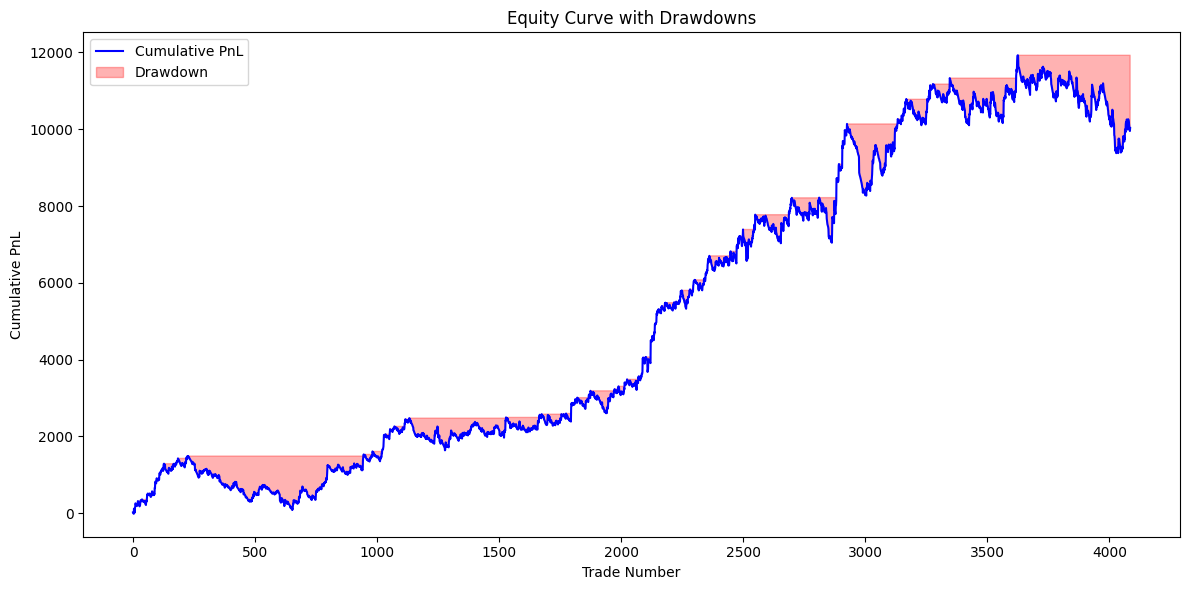

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------
# ✅ 1) Load your trades
# -------------------------------------------
trades_df = pd.read_csv('phase4_trades_trailing_stop.csv')

# -------------------------------------------
# ✅ 2) Basic stats
# -------------------------------------------
total_trades = len(trades_df)
total_pnl = trades_df['PnL'].sum()
avg_pnl = trades_df['PnL'].mean()
win_rate = (trades_df['PnL'] > 0).mean()

print(f"✅ Total Trades: {total_trades}")
print(f"📈 Total PnL: {total_pnl:.2f}")
print(f"📊 Average PnL per Trade: {avg_pnl:.2f}")
print(f"✅ Win Rate: {win_rate:.2%}")

# -------------------------------------------
# ✅ 3) Sharpe Ratio (assumes PnL per trade is daily returns-like)
# -------------------------------------------
returns = trades_df['PnL']
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0

print(f"📈 Sharpe Ratio (annualized): {sharpe_ratio:.2f}")

# -------------------------------------------
# ✅ 4) Max Drawdown
# -------------------------------------------
trades_df['CumPnL'] = trades_df['PnL'].cumsum()
trades_df['Peak'] = trades_df['CumPnL'].cummax()
trades_df['Drawdown'] = trades_df['CumPnL'] - trades_df['Peak']
max_dd = trades_df['Drawdown'].min()

print(f"📉 Max Drawdown: {max_dd:.2f}")

# -------------------------------------------
# ✅ 5) Plot PnL curve
# -------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(trades_df['CumPnL'], label='Cumulative PnL', color='blue')
plt.fill_between(trades_df.index, trades_df['Peak'], trades_df['CumPnL'], 
                 where=(trades_df['CumPnL'] < trades_df['Peak']),
                 color='red', alpha=0.3, label='Drawdown')
plt.title('Equity Curve with Drawdowns')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.tight_layout()
plt.show()



✅ Final capital: 11593906.98
📊 Net % return: 11493.91%


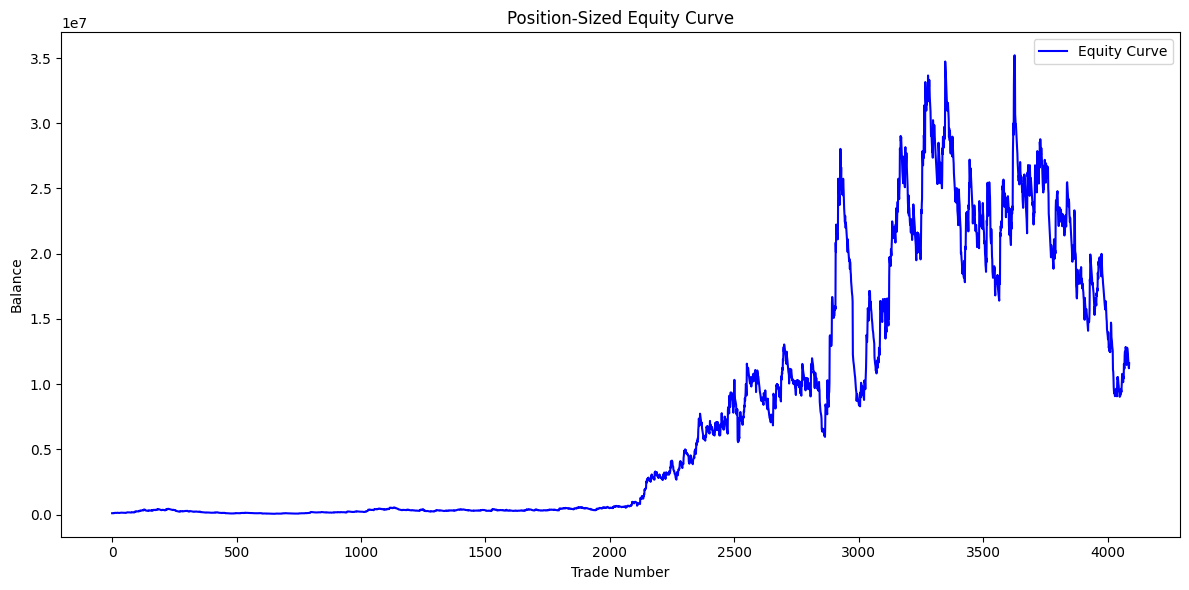

📈 Sharpe Ratio (approx, annualized): 0.09
📉 Max Drawdown: -26184946.45
✅ Position-sized trades saved to 'phase5_trades_position_sizing.csv'


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------
# ✅ 1) Load your Phase 4 trailing stop trades
# -------------------------------------------
trades_df = pd.read_csv('phase4_trades_trailing_stop.csv')

# -------------------------------------------
# ✅ 2) Setup Position Sizing parameters
# -------------------------------------------
initial_balance = 100_000   # your starting capital
risk_pct = 0.01             # risk 1% per trade
SL_pct = 0.001              # matches your backtest stop loss %

balances = [initial_balance]
positions = []
capital = initial_balance

# -------------------------------------------
# ✅ 3) Loop through trades with dynamic sizing
# -------------------------------------------
for i, trade in trades_df.iterrows():
    entry_price = trade['EntryPrice']
    direction = trade['Direction']
    
    # How much you are willing to lose
    risk_per_trade = capital * risk_pct
    
    # Points risked per unit
    points_risked = entry_price * SL_pct
    
    # Units to trade (lot size)
    if points_risked == 0:
        size = 0
    else:
        size = risk_per_trade / points_risked
    
    # Actual PnL for this trade
    actual_pnl = trade['PnL'] * size
    
    # Update capital
    capital += actual_pnl
    balances.append(capital)
    
    positions.append({
        'EntryTime': trade['EntryTime'],
        'ExitTime': trade['ExitTime'],
        'Direction': direction,
        'EntryPrice': entry_price,
        'ExitPrice': trade['ExitPrice'],
        'PnL_points': trade['PnL'],
        'PositionSize': size,
        'PnL_actual': actual_pnl,
        'Reason': trade['Reason'],
        'Balance': capital
    })

# -------------------------------------------
# ✅ 4) Save results to CSV
# -------------------------------------------
positions_df = pd.DataFrame(positions)
positions_df.to_csv('phase5_trades_position_sizing.csv', index=False)

print("\n✅ Final capital: {:.2f}".format(capital))
print("📊 Net % return: {:.2f}%".format(100 * (capital - initial_balance) / initial_balance))

# -------------------------------------------
# ✅ 5) Plot Position-Sized Equity Curve
# -------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(balances, label='Equity Curve', color='blue')
plt.title('Position-Sized Equity Curve')
plt.xlabel('Trade Number')
plt.ylabel('Balance')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------
# ✅ 6) Final performance stats
# -------------------------------------------
returns = positions_df['PnL_actual']
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0

positions_df['Peak'] = positions_df['Balance'].cummax()
positions_df['Drawdown'] = positions_df['Balance'] - positions_df['Peak']
max_dd = positions_df['Drawdown'].min()

print(f"📈 Sharpe Ratio (approx, annualized): {sharpe_ratio:.2f}")
print(f"📉 Max Drawdown: {max_dd:.2f}")
print("✅ Position-sized trades saved to 'phase5_trades_position_sizing.csv'")


In [19]:
import pandas as pd
import numpy as np

# -------------------------------------------
# ✅ 1) Load your base trades
# -------------------------------------------
base_trades = pd.read_csv('phase4_trades_trailing_stop.csv')

# -------------------------------------------
# ✅ 2) Parameter grid
# -------------------------------------------
initial_balance = 100_000
risk_pct_list = [0.001, 0.0025, 0.005, 0.01]     # 0.1% → 1% risk per trade
SL_pct_list = [0.001, 0.0015, 0.002]             # 0.1% → 0.2% stop loss per trade
trailing_buffers = [0.001, 0.0015, 0.002]        # trailing stop distance

results = []

# -------------------------------------------
# ✅ 3) Loop over combinations
# -------------------------------------------
for risk_pct in risk_pct_list:
    for SL_pct in SL_pct_list:
        for trailing_buffer in trailing_buffers:
            capital = initial_balance
            balances = [capital]

            for i, trade in base_trades.iterrows():
                entry_price = trade['EntryPrice']
                points_risked = entry_price * SL_pct

                risk_per_trade = capital * risk_pct
                size = risk_per_trade / points_risked if points_risked != 0 else 0

                actual_pnl = trade['PnL'] * size
                capital += actual_pnl
                balances.append(capital)

            returns = np.diff(balances)  # actual trade PnLs
            sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0

            peak = np.maximum.accumulate(balances)
            drawdowns = balances - peak
            max_dd = drawdowns.min()
            net_return_pct = 100 * (capital - initial_balance) / initial_balance

            results.append({
                'risk_pct': risk_pct,
                'SL_pct': SL_pct,
                'trailing_buffer': trailing_buffer,
                'final_balance': capital,
                'net_return_pct': net_return_pct,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_dd
            })

print("\n✅ Parameter Sweep Results:")
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='sharpe_ratio', ascending=False).reset_index(drop=True)
print(results_df)

results_df.to_csv('parameter_sweep_results.csv', index=False)
print("\n📁 Saved to 'parameter_sweep_results.csv'")



✅ Parameter Sweep Results:
    risk_pct  SL_pct  trailing_buffer  final_balance  net_return_pct  \
0     0.0010  0.0020           0.0010   1.520989e+05       52.098894   
1     0.0010  0.0020           0.0020   1.520989e+05       52.098894   
2     0.0010  0.0020           0.0015   1.520989e+05       52.098894   
3     0.0010  0.0015           0.0010   1.741341e+05       74.134070   
4     0.0010  0.0015           0.0015   1.741341e+05       74.134070   
5     0.0010  0.0015           0.0020   1.741341e+05       74.134070   
6     0.0010  0.0010           0.0010   2.267219e+05      126.721941   
7     0.0010  0.0010           0.0015   2.267219e+05      126.721941   
8     0.0010  0.0010           0.0020   2.267219e+05      126.721941   
9     0.0025  0.0020           0.0020   2.747399e+05      174.739942   
10    0.0025  0.0020           0.0015   2.747399e+05      174.739942   
11    0.0025  0.0020           0.0010   2.747399e+05      174.739942   
12    0.0025  0.0015           0.002


✅ Final capital: 152098.89
📊 Net % return: 52.10%


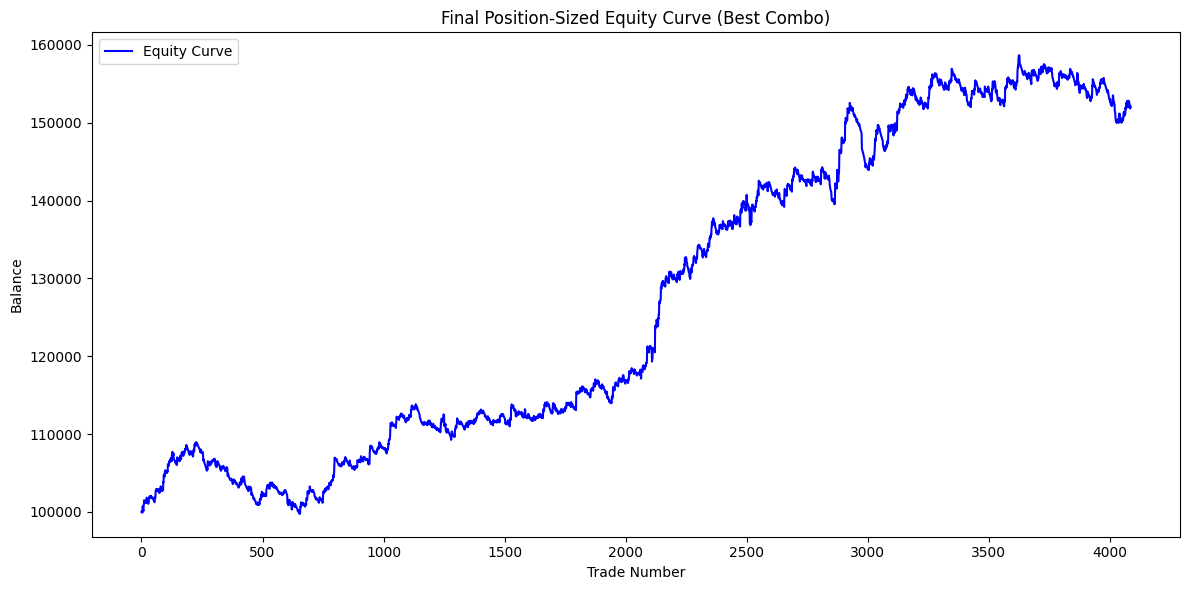

📈 Sharpe Ratio (annualized): 0.70
📉 Max Drawdown: -9202.26
✅ Final position-sized trades saved to 'phase5_trades_position_sizing_best_combo.csv'


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------
# ✅ 1) Load your Phase 4 trades with trailing stop
# -------------------------------------------
trades_df = pd.read_csv('phase4_trades_trailing_stop.csv')

# -------------------------------------------
# ✅ 2) Set your FINAL best parameters
# -------------------------------------------
initial_balance = 100_000
risk_pct = 0.0010   # 0.1% risk per trade
SL_pct   = 0.0020   # 0.2% stop loss
# trailing_buffer already baked into your Phase 4 trades logic!

balances = [initial_balance]
positions = []
capital = initial_balance

# -------------------------------------------
# ✅ 3) Position sizing loop
# -------------------------------------------
for i, trade in trades_df.iterrows():
    entry_price = trade['EntryPrice']
    points_risked = entry_price * SL_pct

    risk_per_trade = capital * risk_pct
    size = risk_per_trade / points_risked if points_risked != 0 else 0

    actual_pnl = trade['PnL'] * size

    capital += actual_pnl
    balances.append(capital)

    positions.append({
        'EntryTime': trade['EntryTime'],
        'ExitTime': trade['ExitTime'],
        'Direction': trade['Direction'],
        'EntryPrice': entry_price,
        'ExitPrice': trade['ExitPrice'],
        'PnL_points': trade['PnL'],
        'PositionSize': size,
        'PnL_actual': actual_pnl,
        'Reason': trade['Reason'],
        'Balance': capital
    })

# -------------------------------------------
# ✅ 4) Save results
# -------------------------------------------
positions_df = pd.DataFrame(positions)
positions_df.to_csv('phase5_trades_position_sizing_best_combo.csv', index=False)

print("\n✅ Final capital: {:.2f}".format(capital))
print("📊 Net % return: {:.2f}%".format(100 * (capital - initial_balance) / initial_balance))

# -------------------------------------------
# ✅ 5) Final equity curve
# -------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(balances, label='Equity Curve', color='blue')
plt.title('Final Position-Sized Equity Curve (Best Combo)')
plt.xlabel('Trade Number')
plt.ylabel('Balance')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------
# ✅ 6) Final stats
# -------------------------------------------
returns = positions_df['PnL_actual']
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0

positions_df['Peak'] = positions_df['Balance'].cummax()
positions_df['Drawdown'] = positions_df['Balance'] - positions_df['Peak']
max_dd = positions_df['Drawdown'].min()

print(f"📈 Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
print(f"📉 Max Drawdown: {max_dd:.2f}")
print("✅ Final position-sized trades saved to 'phase5_trades_position_sizing_best_combo.csv'")



✅ Final capital: 152098.89
📊 Net % return: 52.10%


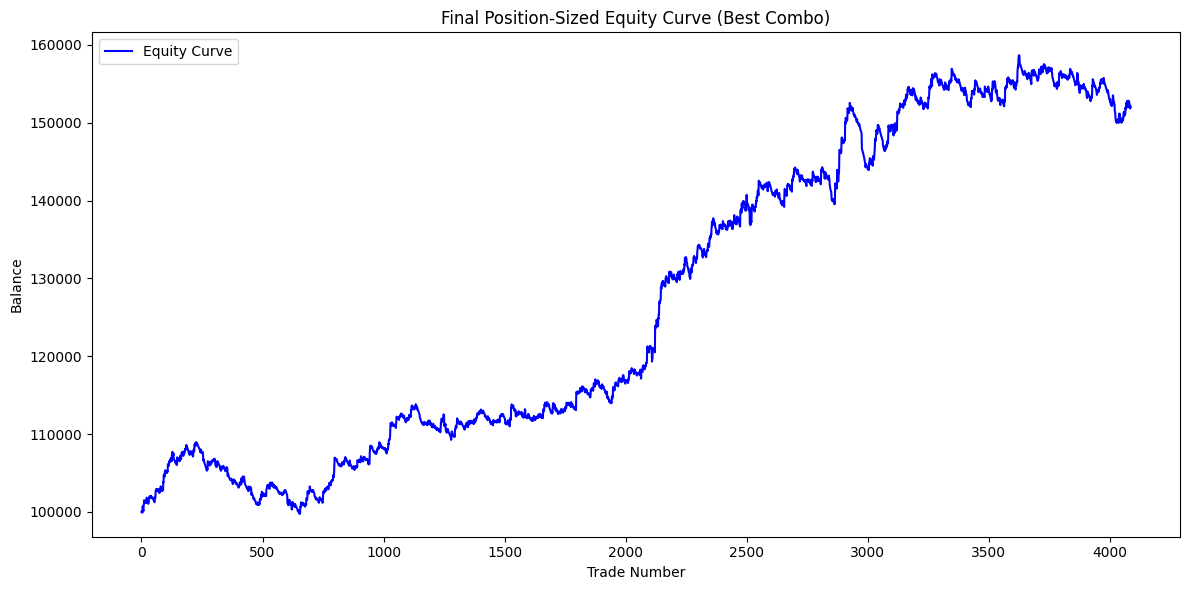

📈 Sharpe Ratio (annualized): 0.70
📉 Max Drawdown: -9202.26
✅ Final position-sized trades saved to 'phase5_trades_position_sizing_best_combo.csv'

📅 Daily stats (first few rows):
    EntryDate  TotalTrades  AveragePnL    TotalPnL
0  2015-01-09            1  125.878114  125.878114
1  2015-01-12            3  -73.941464 -221.824391
2  2015-01-14            1  802.690545  802.690545
3  2015-01-15            1 -327.502570 -327.502570
4  2015-01-19            2 -132.956170 -265.912340

✅ Daily stats saved to 'daily_stats.csv'


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------
# ✅ 1) Load your Phase 4 trades with trailing stop
# -------------------------------------------
trades_df = pd.read_csv('phase4_trades_trailing_stop.csv')

# Ensure EntryTime is in datetime format
trades_df['EntryTime'] = pd.to_datetime(trades_df['EntryTime'])

# -------------------------------------------
# ✅ 2) Set your FINAL best parameters
# -------------------------------------------
initial_balance = 100_000
risk_pct = 0.0010   # 0.1% risk per trade
SL_pct   = 0.0020   # 0.2% stop loss
# trailing_buffer already baked into your Phase 4 trades logic!

balances = [initial_balance]
positions = []
capital = initial_balance

# -------------------------------------------
# ✅ 3) Position sizing loop
# -------------------------------------------
for i, trade in trades_df.iterrows():
    entry_price = trade['EntryPrice']
    points_risked = entry_price * SL_pct

    risk_per_trade = capital * risk_pct
    size = risk_per_trade / points_risked if points_risked != 0 else 0

    actual_pnl = trade['PnL'] * size

    capital += actual_pnl
    balances.append(capital)

    positions.append({
        'EntryTime': trade['EntryTime'],
        'ExitTime': trade['ExitTime'],
        'Direction': trade['Direction'],
        'EntryPrice': entry_price,
        'ExitPrice': trade['ExitPrice'],
        'PnL_points': trade['PnL'],
        'PositionSize': size,
        'PnL_actual': actual_pnl,
        'Reason': trade['Reason'],
        'Balance': capital
    })

# -------------------------------------------
# ✅ 4) Save results
# -------------------------------------------
positions_df = pd.DataFrame(positions)
positions_df.to_csv('phase5_trades_position_sizing_best_combo.csv', index=False)

print("\n✅ Final capital: {:.2f}".format(capital))
print("📊 Net % return: {:.2f}%".format(100 * (capital - initial_balance) / initial_balance))

# -------------------------------------------
# ✅ 5) Final equity curve
# -------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(balances, label='Equity Curve', color='blue')
plt.title('Final Position-Sized Equity Curve (Best Combo)')
plt.xlabel('Trade Number')
plt.ylabel('Balance')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------
# ✅ 6) Final stats
# -------------------------------------------
returns = positions_df['PnL_actual']
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0

positions_df['Peak'] = positions_df['Balance'].cummax()
positions_df['Drawdown'] = positions_df['Balance'] - positions_df['Peak']
max_dd = positions_df['Drawdown'].min()

print(f"📈 Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
print(f"📉 Max Drawdown: {max_dd:.2f}")
print("✅ Final position-sized trades saved to 'phase5_trades_position_sizing_best_combo.csv'")

# -------------------------------------------
# ✅ 7) Daily stats (Average PnL & Total trades per day)
# -------------------------------------------
positions_df['EntryDate'] = pd.to_datetime(positions_df['EntryTime']).dt.date

daily_stats = positions_df.groupby('EntryDate').agg(
    TotalTrades=('PnL_actual', 'count'),
    AveragePnL=('PnL_actual', 'mean'),
    TotalPnL=('PnL_actual', 'sum')
).reset_index()

print("\n📅 Daily stats (first few rows):")
print(daily_stats.head())

# Save daily stats to CSV if needed
daily_stats.to_csv('daily_stats.csv', index=False)
print("\n✅ Daily stats saved to 'daily_stats.csv'")



✅ Final capital: 117937.81
📊 Net % return: 17.94%


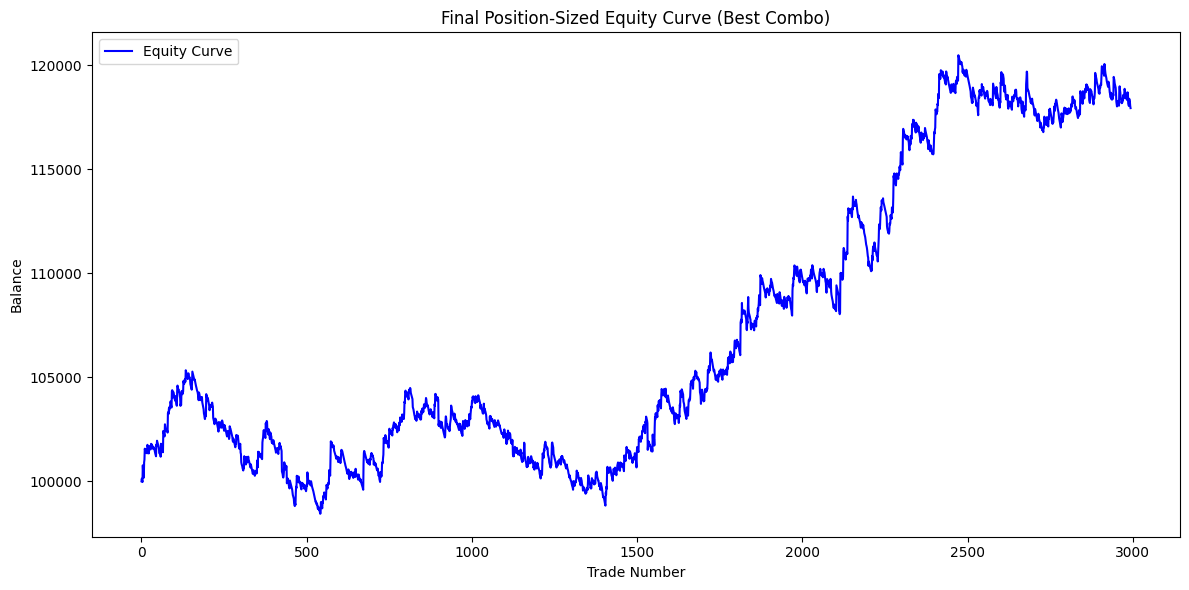

📈 Sharpe Ratio (annualized): 0.45
📉 Max Drawdown: -6898.97
✅ Final position-sized trades saved to 'phase5_trades_position_sizing_best_combo.csv'

📅 Daily stats (first few rows):
    EntryDate  TotalTrades  AveragePnL    TotalPnL
0  2015-01-09            1  125.878114  125.878114
1  2015-01-12            2  -80.556871 -161.113742
2  2015-01-14            1  803.178332  803.178332
3  2015-01-15            1 -327.701590 -327.701590
4  2015-01-19            2 -133.036966 -266.073932

✅ Daily stats saved to 'daily_stats.csv'


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------
# ✅ 1) Load Phase 4 trades with trailing stop
# -------------------------------------------
trades_df = pd.read_csv('phase4_trades_trailing_stop.csv')

# Ensure EntryTime is datetime
trades_df['EntryTime'] = pd.to_datetime(trades_df['EntryTime'])

# Sort by EntryTime just in case
trades_df = trades_df.sort_values('EntryTime').reset_index(drop=True)

# Add EntryDate column
trades_df['EntryDate'] = trades_df['EntryTime'].dt.date

# -------------------------------------------
# ✅ 2) Set final best parameters
# -------------------------------------------
initial_balance = 100_000
risk_pct = 0.0010   # 0.1% risk per trade
SL_pct   = 0.0020   # 0.2% stop loss

balances = [initial_balance]
positions = []
capital = initial_balance

# -------------------------------------------
# ✅ 3) Position sizing loop with daily trade limit
# -------------------------------------------
current_date = None
trades_taken_today = 0
successful_trade_today = False

for i, trade in trades_df.iterrows():
    entry_date = trade['EntryDate']

    # Reset daily counters if new day
    if entry_date != current_date:
        current_date = entry_date
        trades_taken_today = 0
        successful_trade_today = False

    # If already hit daily limit or success, skip trade
    if trades_taken_today >= 2 or successful_trade_today:
        continue

    entry_price = trade['EntryPrice']
    points_risked = entry_price * SL_pct

    risk_per_trade = capital * risk_pct
    size = risk_per_trade / points_risked if points_risked != 0 else 0

    actual_pnl = trade['PnL'] * size

    capital += actual_pnl
    balances.append(capital)

    positions.append({
        'EntryTime': trade['EntryTime'],
        'ExitTime': trade['ExitTime'],
        'Direction': trade['Direction'],
        'EntryPrice': entry_price,
        'ExitPrice': trade['ExitPrice'],
        'PnL_points': trade['PnL'],
        'PositionSize': size,
        'PnL_actual': actual_pnl,
        'Reason': trade['Reason'],
        'Balance': capital
    })

    trades_taken_today += 1

    # If this trade was profitable, mark the day as successful
    if actual_pnl > 0:
        successful_trade_today = True

# -------------------------------------------
# ✅ 4) Save results
# -------------------------------------------
positions_df = pd.DataFrame(positions)
positions_df.to_csv('phase5_trades_position_sizing_best_combo.csv', index=False)

print("\n✅ Final capital: {:.2f}".format(capital))
print("📊 Net % return: {:.2f}%".format(100 * (capital - initial_balance) / initial_balance))

# -------------------------------------------
# ✅ 5) Final equity curve
# -------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(balances, label='Equity Curve', color='blue')
plt.title('Final Position-Sized Equity Curve (Best Combo)')
plt.xlabel('Trade Number')
plt.ylabel('Balance')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------
# ✅ 6) Final stats
# -------------------------------------------
returns = positions_df['PnL_actual']
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0

positions_df['Peak'] = positions_df['Balance'].cummax()
positions_df['Drawdown'] = positions_df['Balance'] - positions_df['Peak']
max_dd = positions_df['Drawdown'].min()

print(f"📈 Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
print(f"📉 Max Drawdown: {max_dd:.2f}")
print("✅ Final position-sized trades saved to 'phase5_trades_position_sizing_best_combo.csv'")

# -------------------------------------------
# ✅ 7) Daily stats (Average PnL & Total trades per day)
# -------------------------------------------
positions_df['EntryDate'] = pd.to_datetime(positions_df['EntryTime']).dt.date

daily_stats = positions_df.groupby('EntryDate').agg(
    TotalTrades=('PnL_actual', 'count'),
    AveragePnL=('PnL_actual', 'mean'),
    TotalPnL=('PnL_actual', 'sum')
).reset_index()

print("\n📅 Daily stats (first few rows):")
print(daily_stats.head())

# Save daily stats to CSV if needed
daily_stats.to_csv('daily_stats.csv', index=False)
print("\n✅ Daily stats saved to 'daily_stats.csv'")
